<a href="https://colab.research.google.com/github/SergeiVKalinin/MSE_Fall2024/blob/main/Module_8/27__Causal_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Causal discovery with RAG
- Based on the A. Molak https://towardsdatascience.com/jane-the-discoverer-enhancing-causal-discovery-with-large-language-models-causal-python-564a63425c93
- **Caution:** add your own open OpenAI key

In [ ]:
!pip install wikipedia
!pip install openai

!pip install langchain
!pip install -U langchain-community

!pip install gcastle

  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11680 sha256=6957048ceecd639d676bb478fe9d21b2bbd7450e5ffd317690772a81ffb511c5
  Stored in directory: /root/.cache/pip/wheels/5e/b6/c5/93f3dec388ae76edc830cb42901bb0232504dfc0df02fc50de
Successfully built wikipedia
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.3/328.3 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 975.5/975.5 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 337.4/337.4 kB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.5/127.5 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━

In [ ]:
import os
from itertools import combinations

import numpy as np
from scipy import linalg
from scipy import stats

import matplotlib.pyplot as plt

from langchain.agents import load_tools, initialize_agent
from langchain.agents import AgentType

from langchain.chat_models import ChatOpenAI

from castle.common import GraphDAG
from castle.metrics import MetricsDAG
from castle.algorithms import PC

from castle.common.priori_knowledge import PrioriKnowledge

In [ ]:
#with open(r'my_folder/my_openai_key.dat') as f:
#    key = f.read()

os.environ['OPENAI_API_KEY'] = [add own key]

In [ ]:
def check_if_dag(A):
    return np.trace(linalg.expm(A * A)) - A.shape[0] == 0

In [ ]:
all_vars = {
    'altitude': 0,
    'oxygen_density': 1,
    'temperature': 2,
    'risk_of_death': 3,
    'mehendretex': 4
}

In [ ]:
SAMPLE_SIZE = 1000

altitude = stats.halfnorm.rvs(scale=2000, size=SAMPLE_SIZE)
temperature = 25 - altitude / 100 + stats.norm.rvs(
    loc=0,
    scale=2,
    size=SAMPLE_SIZE
)

mehendretex = stats.halfnorm.rvs(size=SAMPLE_SIZE)

oxygen_density = np.clip(
    1 - altitude / 8000
    - temperature / 50
    + stats.norm.rvs(size=SAMPLE_SIZE) / 20,
    0,
    1)

risk_of_death = np.clip(
    altitude / 20000
    + np.abs(temperature) / 100
    - oxygen_density / 5
    - mehendretex / 5
    + stats.norm.rvs(size=SAMPLE_SIZE) / 10,
    0,
    1
)

In [ ]:
dataset = np.stack(
    [
        altitude,
        oxygen_density,
        temperature,
        risk_of_death,
        mehendretex
    ]
).T

In [ ]:
true_dag = np.array(
    [
        [0, 1, 1, 1, 0],
        [0, 0, 0, 1, 0],
        [0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0]
    ]
)

Is learned matrix a DAG: False


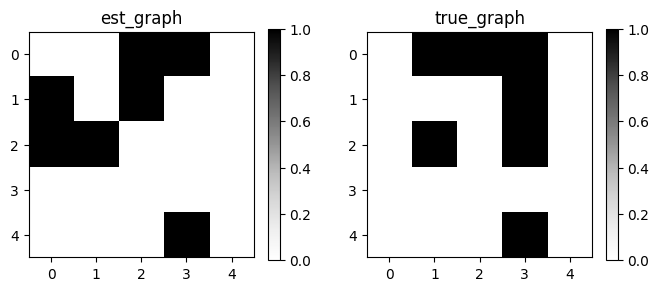

{'fdr': 0.2, 'tpr': 0.5714, 'fpr': 0.3333, 'shd': 3, 'nnz': 5, 'precision': 0.5714, 'recall': 0.5714, 'F1': 0.5714, 'gscore': 0.1429}


In [ ]:
# PC discovery without LLM assist
pc = PC(variant='stable')
pc.learn(dataset)

print(f'Is learned matrix a DAG: {check_if_dag(pc.causal_matrix)}')

# Vizualize
GraphDAG(
    est_dag=pc.causal_matrix,
    true_dag=true_dag)

plt.show()

# Compute metrics
metrics = MetricsDAG(
    B_est=pc.causal_matrix,
    B_true=true_dag)

print(metrics.metrics)

In [ ]:
# Instantiate and encode priori knowledge
priori_knowledge = PrioriKnowledge(n_nodes=len(all_vars))

In [ ]:
import openai

In [ ]:
llm = ChatOpenAI(
    temperature=0, # Temp == 0 => we want clear reasoning
    model='gpt-3.5-turbo')#'gpt-3.5-turbo' gpt-4)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(


In [ ]:
# Load tools
tools = load_tools(
    [
        "wikipedia"
    ],
    llm=llm)

In [ ]:
# Instantiate the agent
agent = initialize_agent(
    tools,
    llm,
    agent=AgentType.CHAT_ZERO_SHOT_REACT_DESCRIPTION,
    handle_parsing_errors=True,
    verbose=False)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The function `initialize_agent` was deprecated in LangChain 0.1.0 and will be removed in 0.3.0. Use Use new agent constructor methods like create_react_agent, create_json_agent, create_structured_chat_agent, etc. instead.
  warn_deprecated(


In [ ]:
'''
llm = ChatOpenAI(temperature=0, model='gpt-3.5-turbo')
tools = load_tools(["arxiv"], llm=llm)
agent = initialize_agent(tools, llm, agent=AgentType.CHAT_ZERO_SHOT_REACT_DESCRIPTION,
    handle_parsing_errors=True, verbose=False)
    '''

In [ ]:
def get_llm_info(llm, agent, var_1, var_2):

    out = agent(f"Does {var_1} cause {var_2} or the other way around?\
    We assume the following definition of causation:\
    if we change A, B will also change.\
    The relationship does not have to be linear or monotonic.\
    We are interested in all types of causal relationships, including\
    partial and indirect relationships, given that our definition holds.\
    ")

    print(out)

    pred = llm.predict(f'We assume the following definition of causation:\
    if we change A, B will also change.\
    Based on the following information: {out["output"]},\
    print (0,1) if {var_1} causes {var_2},\
    print (1, 0) if {var_2} causes {var_1}, print (0,0)\
    if there is no causal relationship between {var_1} and {var_2}.\
    Finally, print (-1, -1) if you don\'t know. Importantly, don\'t try to\
    make up an answer if you don\'t know.')

    print(pred)

    return pred

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


altitude oxygen_density
{'input': 'Does altitude cause oxygen_density or the other way around?    We assume the following definition of causation:    if we change A, B will also change.    The relationship does not have to be linear or monotonic.    We are interested in all types of causal relationships, including    partial and indirect relationships, given that our definition holds.    ', 'output': 'Altitude causes changes in oxygen density, leading to physiological effects on the human body.'}


/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `BaseChatModel.predict` was deprecated in langchain-core 0.1.7 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


(0,1)
altitude temperature
{'input': 'Does altitude cause temperature or the other way around?    We assume the following definition of causation:    if we change A, B will also change.    The relationship does not have to be linear or monotonic.    We are interested in all types of causal relationships, including    partial and indirect relationships, given that our definition holds.    ', 'output': 'Altitude can indirectly influence temperature through its effects on atmospheric pressure and oxygen levels.'}
(0, 1)
altitude risk_of_death
{'input': 'Does altitude cause risk_of_death or the other way around?    We assume the following definition of causation:    if we change A, B will also change.    The relationship does not have to be linear or monotonic.    We are interested in all types of causal relationships, including    partial and indirect relationships, given that our definition holds.    ', 'output': 'Altitude can impact health, leading to conditions like altitude sickness, 

/usr/local/lib/python3.10/dist-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /usr/local/lib/python3.10/dist-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')
/usr/local/lib/python3.10/dist-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave diff

{'input': 'Does oxygen_density cause risk_of_death or the other way around?    We assume the following definition of causation:    if we change A, B will also change.    The relationship does not have to be linear or monotonic.    We are interested in all types of causal relationships, including    partial and indirect relationships, given that our definition holds.    ', 'output': 'The causal relationship between oxygen density and risk of death is not directly addressed in the information provided. Further analysis or research would be needed to determine the specific causal relationship between these two variables.'}
(-1, -1)
oxygen_density mehendretex
{'input': 'Does oxygen_density cause mehendretex or the other way around?    We assume the following definition of causation:    if we change A, B will also change.    The relationship does not have to be linear or monotonic.    We are interested in all types of causal relationships, including    partial and indirect relationships, gi

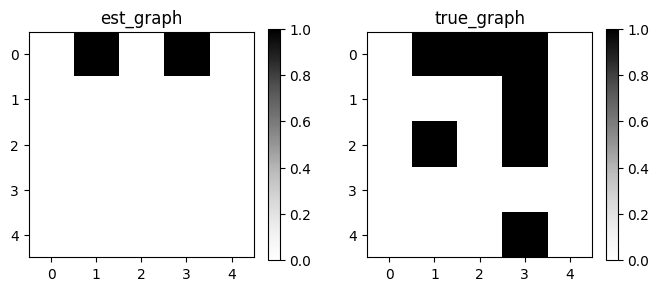


Running PC


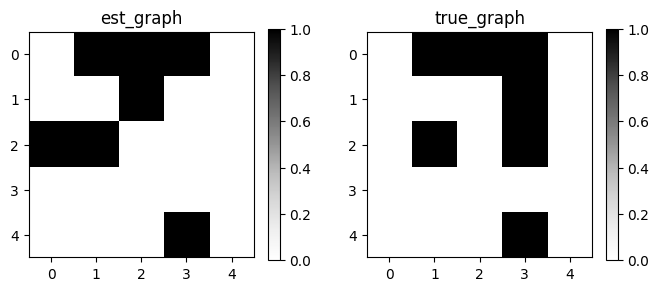

{'fdr': 0.0, 'tpr': 0.7143, 'fpr': 0.0, 'shd': 2, 'nnz': 5, 'precision': 0.7143, 'recall': 0.7143, 'F1': 0.7143, 'gscore': 0.4286}


In [ ]:
for var_1, var_2 in combinations(all_vars.keys(), r=2):
    print(var_1, var_2)
    out = get_llm_info(llm, agent, var_1, var_2)
    if out=='(0,1)':
        priori_knowledge.add_required_edges(
            [(all_vars[var_1], all_vars[var_2])]
        )

        priori_knowledge.add_forbidden_edges(
            [(all_vars[var_2], all_vars[var_1])]
        )

    elif out=='(1,0)':
        priori_knowledge.add_required_edges(
            [(all_vars[var_2], all_vars[var_1])]
        )
        priori_knowledge.add_forbidden_edges(
            [(all_vars[var_1], all_vars[var_2])]
        )

print('\nLLM knowledge vs true DAG')
priori_dag = np.clip(priori_knowledge.matrix, 0, 1)

print(f'\nChecking if priori graph is a DAG: {check_if_dag(priori_dag)}')

GraphDAG(
    est_dag=priori_dag,
    true_dag=true_dag)

plt.show()

print('\nRunning PC')

# Instantiate the model with expert knowledge
pc_priori = PC(
    priori_knowledge=priori_knowledge,
    variant='stable'
)

# Learn
pc_priori.learn(dataset)

GraphDAG(
    est_dag=pc_priori.causal_matrix,
    true_dag=true_dag)

plt.show()

# Compute metrics
metrics = MetricsDAG(
    B_est=pc_priori.causal_matrix,
    B_true=true_dag)

print(metrics.metrics)